# **Project 2**

#### **The Problem**

This project builds off of my previous project, and takes into consideration a significantly larger number of predictors. While still being applicable to the conflict in Ukraine, this project is still relevent to any military force wishing to predict outcomes of battles they may face, and determine whether or not an engagement is worth taking based on the current situation. As was established in my previous project, one of the biggest factors that determines if a battle is one is whether or not you are the attacker, so for this project, all variables are taken from the view of the attacker. 

In [62]:
#Importing relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split as tts
from sklearn import tree
from sklearn import ensemble

### **The Data**

Once again, this data is from Kaggle, and is a dataset of over 600 historical battles ranging from the 17th century to the 20th century. A significant number of variables are included such as the name of the conflict, the name of the attacker, weather and terrain conditions, advantages held by either side, and of course, the outcome of the battle.

A link to the dataset will be provided below.

https://www.kaggle.com/datasets/residentmario/database-of-battles?select=battles.csv

In [31]:
#Pulling in the datasets to work with while separating the variables we are interested in
battle_mn = pd.read_csv('battles.csv')
battle_mn = battle_mn[['isqno', 'post1','surpa','trnga','logsa','wina']]

#The last 50 or so observations are eliminated due to large gaps in missing data
battle_mn = battle_mn[:626]
terr_mn = pd.read_csv('terrain.csv')
terr_mn = terr_mn[['isqno','terra1','terra2']]
terr_mn = terr_mn.drop_duplicates(subset='isqno',keep='first')
weather_mn = pd.read_csv('weather.csv')
weather_mn = weather_mn[['isqno','wx1','wx2','wx4','wx5']]
weather_mn = weather_mn.drop_duplicates(subset='isqno',keep='first')

#Merging the data for battles, terrain, and weather on the isqno (Battle id number)
totals_df = pd.merge(battle_mn,terr_mn,validate='many_to_many')
totals_df = pd.merge(totals_df,weather_mn,validate='many_to_many')

### **Pre-Processing**

Much like before, I can now begin to process and work with the data, forming it into something I can actually turn into a model. Specific considerations were taken into account while working with this data, the largest being that most missing values were replaced with -1. This was done because documentation for the data lists negative numbers as possible values, but no negatives are found within the downloaded data, thus the replacement. For situations such as surprise, training, and logistic advantage, 2s and 3s (indicating a more significant advantage) were replaced with 1, which was done because we are not concerned about the degree of the advantage held, but simply whether or not there was one. Dummy variables were also created, albeit in a simpler, time consuming manner.


First, lets get a look with what we're working with.

In [10]:
print(totals_df.shape)
print(totals_df.isna().sum())

(625, 12)
isqno       0
post1       0
surpa      15
trnga     102
logsa      23
wina      211
terra1      6
terra2      8
wx1         1
wx2        53
wx4         0
wx5         0
dtype: int64


In [32]:
#Renaming variables to something that makes a little more sense
totals_df = totals_df.rename(columns = {'isqno':'Battle_ID','post1':'Defensive_Posture','surpa':'Surprise_Adv','trnga':'Training_Adv','logsa':'Logistic_Adv',
                            'wina':'Win','terra1':'Topography','terra2':'Foliage','wx1':'Precip.','wx2':'Cloud_Cov','wx4':'Season','wx5':'Climate'})

#Replacing Na's with -1 and 2s and 3s with 1 since we don't care about the degree of an advantage, just if there was one
totals_df['Training_Adv'] = totals_df['Training_Adv'].replace(float('NaN'),-1)
totals_df['Training_Adv'] = totals_df['Training_Adv'].replace(2,1)
totals_df['Logistic_Adv'] = totals_df['Logistic_Adv'].replace(float('NaN'),-1)
totals_df['Surprise_Adv'] = totals_df['Surprise_Adv'].replace(float('NaN'),-1)
totals_df['Surprise_Adv'] = totals_df['Surprise_Adv'].replace(2,1)
totals_df['Surprise_Adv'] = totals_df['Surprise_Adv'].replace(3,1)
totals_df['Win'] = totals_df['Win'].replace(float('NaN'),-1)
totals_df['Cloud_Cov'] = totals_df['Cloud_Cov'].replace(float('NaN'),'O')

#Dropping Na values
totals_df = totals_df.dropna()
print(totals_df.shape)
print(totals_df.isna().sum())

(616, 12)
Battle_ID            0
Defensive_Posture    0
Surprise_Adv         0
Training_Adv         0
Logistic_Adv         0
Win                  0
Topography           0
Foliage              0
Precip.              0
Cloud_Cov            0
Season               0
Climate              0
dtype: int64


After replacing values and dropping all other NAs, we retained a significant amount of what we started with.

In [33]:
#Creating dummy variables for the predictors that aren't already numeric, though in retrospect, using get_dummies() would have been easier
totals_df.loc[totals_df['Defensive_Posture']=='HD','Hasty'] = 1
totals_df.loc[totals_df['Defensive_Posture']!='HD','Hasty'] = 0
totals_df.loc[totals_df['Defensive_Posture']=='PD','Prepared'] = 1
totals_df.loc[totals_df['Defensive_Posture']!='PD','Prepared'] = 0
totals_df.loc[totals_df['Defensive_Posture']=='FD','Fortified'] = 1
totals_df.loc[totals_df['Defensive_Posture']!='FD','Fortified'] = 0
totals_df.loc[totals_df['Topography']=='R','Rolling_Top.'] = 1
totals_df.loc[totals_df['Topography']!='R','Rolling_Top.'] = 0
totals_df.loc[totals_df['Topography']=='G','Rugged_Top.'] = 1
totals_df.loc[totals_df['Topography']!='G','Rugged_Top.'] = 0
totals_df.loc[totals_df['Topography']=='F','Flat_Top.'] = 1
totals_df.loc[totals_df['Topography']!='F','Flat_Top.'] = 0
totals_df.loc[totals_df['Precip.']=='W','Wet_Cond.'] = 1
totals_df.loc[totals_df['Precip.']!='W','Wet_Cond.'] = 0
totals_df.loc[totals_df['Precip.']=='D','Dry_Cond.'] = 1
totals_df.loc[totals_df['Precip.']!='D','Dry_Cond.'] = 0
totals_df.loc[totals_df['Foliage']=='F','No_Fol.'] = 1
totals_df.loc[totals_df['Foliage']!='F','No_Fol.'] = 0
totals_df.loc[totals_df['Foliage']=='F','Mixed_Fol.'] = 1
totals_df.loc[totals_df['Foliage']!='F','Mixed_Fol.'] = 0
totals_df.loc[totals_df['Foliage']=='F','Desert'] = 1
totals_df.loc[totals_df['Foliage']!='F','Desert'] = 0
totals_df.loc[totals_df['Foliage']=='F','Heavy_Fol.'] = 1
totals_df.loc[totals_df['Foliage']!='F','Heavy_Fol.'] = 0
totals_df

,Battle_ID,Defensive_Posture,Surprise_Adv,Training_Adv,Logistic_Adv,Win,Topography,Foliage,Precip.,Cloud_Cov,...,Fortified,Rolling_Top.,Rugged_Top.,Flat_Top.,Wet_Cond.,Dry_Cond.,No_Fol.,Mixed_Fol.,Desert,Heavy_Fol.
0,1,HD,0.0,0.0,0.0,-1.0,R,B,D,S,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,2,HD,0.0,0.0,0.0,1.0,R,M,D,S,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,3,HD,0.0,0.0,0.0,1.0,R,M,D,S,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,4,PD,-1.0,0.0,0.0,-1.0,R,M,D,S,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,5,HD,0.0,0.0,0.0,1.0,R,M,D,S,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,621,PD,1.0,1.0,0.0,1.0,G,W,D,O,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
621,622,HD,1.0,0.0,0.0,1.0,R,M,D,O,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
622,623,PD,1.0,1.0,0.0,1.0,G,W,D,O,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
623,624,HD,1.0,0.0,0.0,1.0,G,W,D,O,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### **Visualization**

I decided upon the same method of visualization this go around as my previous project, due to it being very simple to read and understand. Since I would have to create 30+ charts to view every possible situation, I just picked out a few possibilities I found particularly interesting.

In [34]:
#Picking out some interesting variables to get a sense of how important they could be
hasty = totals_df[totals_df['Defensive_Posture']=='HD']
hasty_cts = hasty['Win'].value_counts()
prep = totals_df[totals_df['Defensive_Posture']=='PD']
prep_cts = prep['Win'].value_counts()
fort = totals_df[totals_df['Defensive_Posture']=='FD']
fort_cts = fort['Win'].value_counts()
surp = totals_df[totals_df['Surprise_Adv']==1]
surp_cts = surp['Win'].value_counts()
wet = totals_df[totals_df['Precip.']=='W']
wet_cts = wet['Win'].value_counts()


Text(0.5, 1.0, 'Outcomes with Wet Conditions')

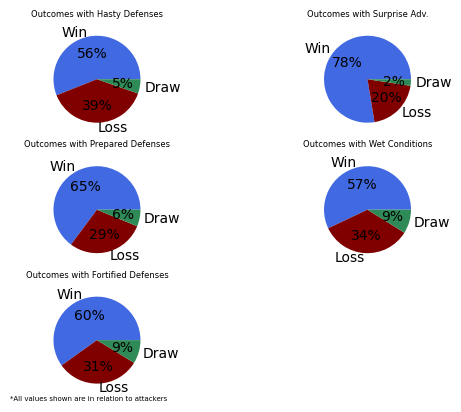

In [35]:
#Creating pie charts for each of the variables
plt.subplot(3,2,1)
plt.pie(hasty_cts,labels = ['Win','Loss','Draw'], autopct='%.0f%%',colors=['royalblue','maroon','seagreen'])
plt.title('Outcomes with Hasty Defenses', fontsize = 6)
plt.subplot(3,2,3)
plt.pie(prep_cts,labels = ['Win','Loss','Draw'], autopct='%.0f%%',colors=['royalblue','maroon','seagreen'])
plt.title('Outcomes with Prepared Defenses', fontsize = 6)
plt.subplot(3,2,5)
plt.pie(fort_cts,labels = ['Win','Loss','Draw'], autopct='%.0f%%',colors=['royalblue','maroon','seagreen'])
plt.title('Outcomes with Fortified Defenses', fontsize = 6)
plt.text(-2,-1.4,'*All values shown are in relation to attackers',fontsize = 5)
plt.subplot(3,2,2)
plt.pie(surp_cts,labels = ['Win','Loss','Draw'], autopct='%.0f%%',colors=['royalblue','maroon','seagreen'])
plt.title('Outcomes with Surprise Adv.', fontsize = 6)
plt.subplot(3,2,4)
plt.pie(wet_cts,labels = ['Win','Loss','Draw'], autopct='%.0f%%',colors=['royalblue','maroon','seagreen'])
plt.title('Outcomes with Wet Conditions', fontsize = 6)


As expected, the pie charts showing the type of defensive posture were very close to those shown last time. Also it comes to no surprise (pun intended), that should the attacker gain the element of surprise, they win a very large majority of their battles. Finally, something I was not sure what to expect, when attackers fought under wet conditions, they only won about half of their battles. One possible reason for this could be that wet conditions make it difficult to maneuver, putting attackers at a disadvantage. Also addressed previously, most all charts that could be created will show the attackers as winning, which I contribute to attackers only attacking enemies that they are confident they can defeat, hence the large skew in attacker victories.

### **Modeling**

Below begins the process of creating models for the features. Since I have a very significant amount of features, I'm rather worried that a simple decision tree would overfit the data, and while I still created a decision tree, I took other actions to attempt to remedy this situation. First, I decided that much like the visualizations, I would make a few models, picking out some of the variables I thought may make the most difference. Secondly, I decided to make a random forest models for each of these situations, since random forests create an ensemble of decision trees to come to an agreement on which features are the most important, I decided that this would be an opportune time to begin testing out how random forests work.


So I have chosen three situations to model, none of which includes the features cloud cover, season and the climate of the battle (I feel that these variables will either have no effect, or are difficult to measure assuming an attacker may not be accustomed to a climate, and this cannoth be measured). One model includes all remaining features, another includes surprise, training, logistics, defensive posture and precipitation. The final model includes surprise, training, logistics, topography and foliage.

In [51]:
#Features included: Surprise, training, logistics, defensive posture, topography, precipitation and foliage
feats = totals_df.drop(columns=['Battle_ID','Defensive_Posture','Topography','Foliage','Precip.','Cloud_Cov','Season','Climate','Win'])

#Features included: Surprise, training, logistics, defense and precipitation
feats_def_precip = totals_df.drop(columns=['Battle_ID','Defensive_Posture','Topography','Foliage','Precip.','Cloud_Cov','Season','Climate','Win',
                                'Rolling_Top.','Rugged_Top.','Flat_Top.','No_Fol.','Mixed_Fol.','Desert','Heavy_Fol.'])

#Features included: Surprise, training, logistics, topography and foliage
feats_top_fol = totals_df.drop(columns=['Battle_ID','Defensive_Posture','Topography','Foliage','Precip.','Cloud_Cov','Season','Climate','Win',
                                'Hasty','Prepared','Fortified','Wet_Cond.','Dry_Cond.'])

target = totals_df['Win']
feats

,Surprise_Adv,Training_Adv,Logistic_Adv,Hasty,Prepared,Fortified,Rolling_Top.,Rugged_Top.,Flat_Top.,Wet_Cond.,Dry_Cond.,No_Fol.,Mixed_Fol.,Desert,Heavy_Fol.
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
621,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
622,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
623,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [66]:
#Establishing a baseline model
print(target.value_counts())
print('\nBaseline model : '+str(round((369/616)*100,2)))

Win
 1.0    369
-1.0    207
 0.0     40
Name: count, dtype: int64

Baseline model : 59.9


In [52]:
#Creating training and testing sets for each situation
feat_train ,feat_test ,target_train ,target_test = tts(feats, target, test_size=.2)
dp_feat_train ,dp_feat_test ,dp_target_train ,dp_target_test = tts(feats_def_precip, target, test_size=.2)
tf_feat_train ,tf_feat_test ,tf_target_train ,tf_target_test = tts(feats_top_fol, target, test_size=.2)

In [53]:
#Creating Decision Trees for each situation
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(feat_train,target_train)
dp_clf_tree = tree.DecisionTreeClassifier()
dp_clf_tree = dp_clf_tree.fit(dp_feat_train,dp_target_train)
tf_clf_tree = tree.DecisionTreeClassifier()
tf_clf_tree = tf_clf_tree.fit(tf_feat_train,tf_target_train)

In [54]:
#Creating forests for each situation
forest = ensemble.RandomForestClassifier()
forest = forest.fit(feat_train,target_train)
dp_forest = ensemble.RandomForestClassifier()
dp_forest = dp_forest.fit(dp_feat_train,dp_target_train)
tf_forest = ensemble.RandomForestClassifier()
tf_forest = tf_forest.fit(tf_feat_train,tf_target_train)

In [55]:
pred_tree_outcomes = clf_tree.predict(feat_test)
pred_forest_outcomes = forest.predict(feat_test)
pred_dp_tree_outcomes = dp_clf_tree.predict(dp_feat_test)
pred_dp_forest_outcomes = dp_forest.predict(dp_feat_test)
pred_tf_tree_outcomes = tf_clf_tree.predict(tf_feat_test)
pred_tf_forest_outcomes = tf_forest.predict(tf_feat_test)

In [57]:
#Printing accuracies for each forest or tree
forest_acc = round((forest.score(feat_test,target_test)*100),2)
tree_acc = round((clf_tree.score(feat_test,target_test)*100),2)
dp_forest_acc = round((dp_forest.score(dp_feat_test,dp_target_test)*100),2)
dp_tree_acc = round((dp_clf_tree.score(dp_feat_test,dp_target_test)*100),2)
tf_forest_acc = round((tf_forest.score(tf_feat_test,tf_target_test)*100),2)
tf_tree_acc = round((tf_clf_tree.score(tf_feat_test,tf_target_test)*100),2)
print('Accuracy of Random Forest with all features: '+ str(forest_acc)+'%')
print('Accuracy of Decision Tree with all features: '+ str(tree_acc)+'%\n')
print('Accuracy of Random Forest with Defensive Posture and Precipitation: '+ str(dp_forest_acc)+'%')
print('Accuracy of Decision Tree with Defensive Posture and Precipitation: '+ str(dp_tree_acc)+'%\n')
print('Accuracy of Random Forest with Topography and Foliage: '+ str(tf_forest_acc)+'%')
print('Accuracy of Decision Tree with Topography and Foliage: '+ str(tf_tree_acc)+'%')

Accuracy of Random Forest with all features: 64.52%
Accuracy of Decision Tree with all features: 58.06%

Accuracy of Random Forest with Defensive Posture and Precipitation: 62.9%
Accuracy of Decision Tree with Defensive Posture and Precipitation: 63.71%

Accuracy of Random Forest with Topography and Foliage: 54.84%
Accuracy of Decision Tree with Topography and Foliage: 54.84%


### **Model(s) Analysis**

Above are the accuracy scores for each of the models. It can be seen that the most accurate model is that of the random forest including all of the features. The models with the lowest accuracy are the models including the topography and foliage of the battlefield, which would hint that these variables are not as important when it comes to determining whether or not you would win a battle, which does honestly come as a surprise to me, since from prior knowledge, plentiful cover and concealment are incredibly important when picking when and where to engage enemy.


Below are the first few levels of the decision tree models for each situation. 

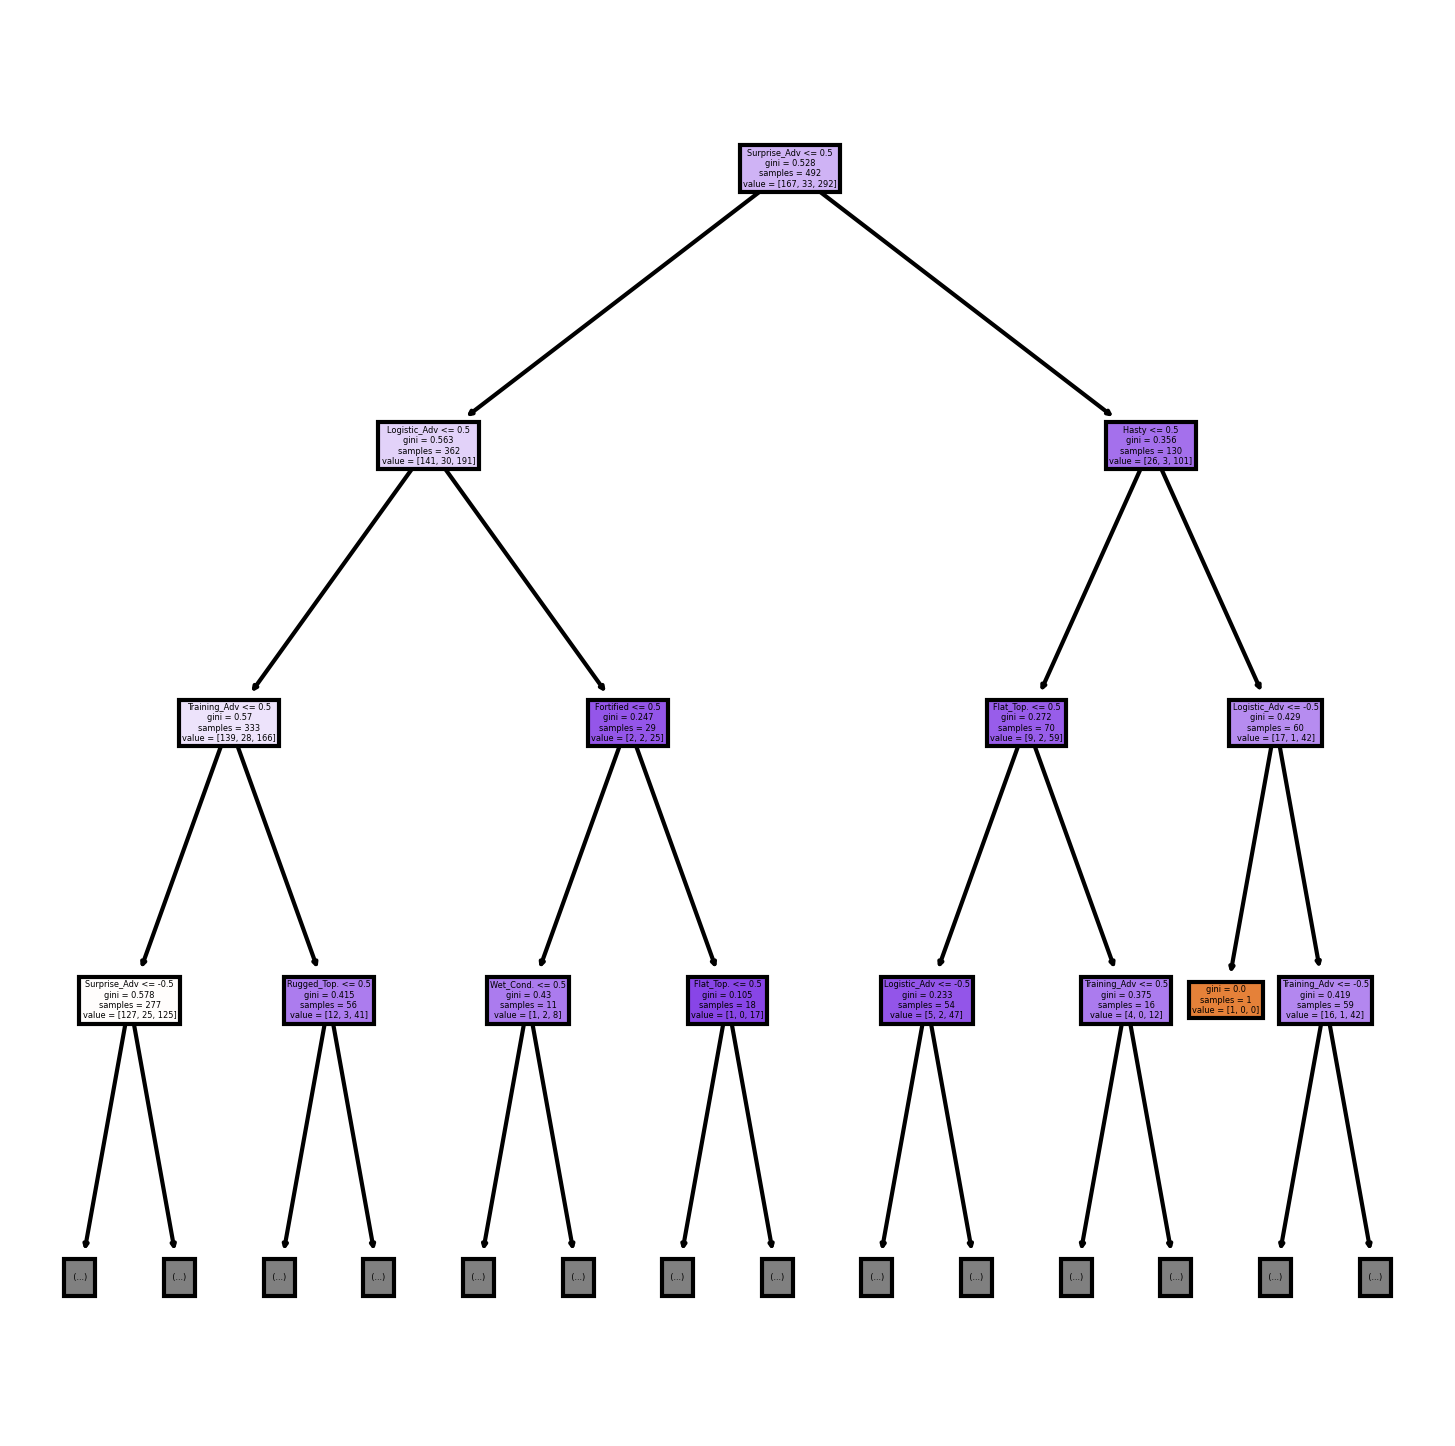

In [59]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (6,6), dpi=300)
tree.plot_tree(clf_tree, max_depth=3,feature_names = list(feats.columns), filled=True)
plt.show()

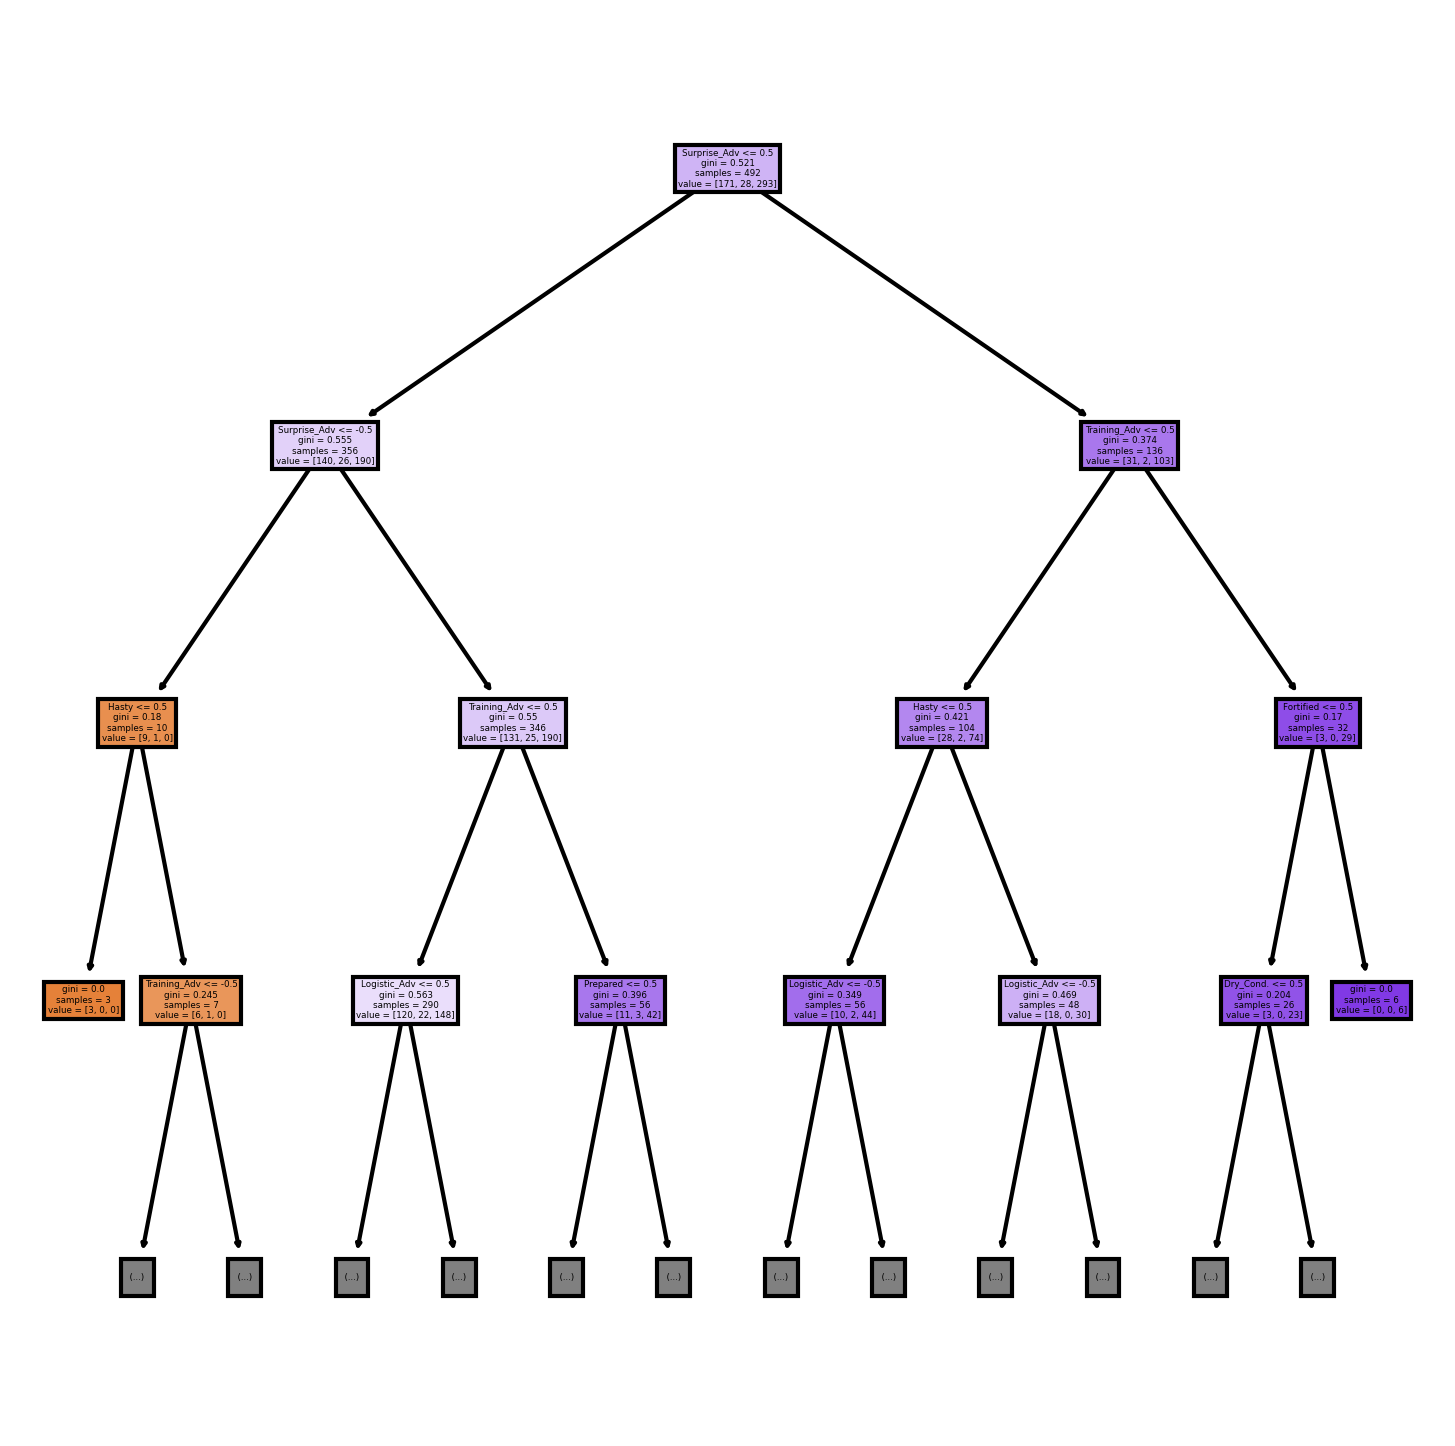

In [60]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (6,6), dpi=300)
tree.plot_tree(dp_clf_tree, max_depth=3,feature_names = list(feats_def_precip.columns), filled=True)
plt.show()

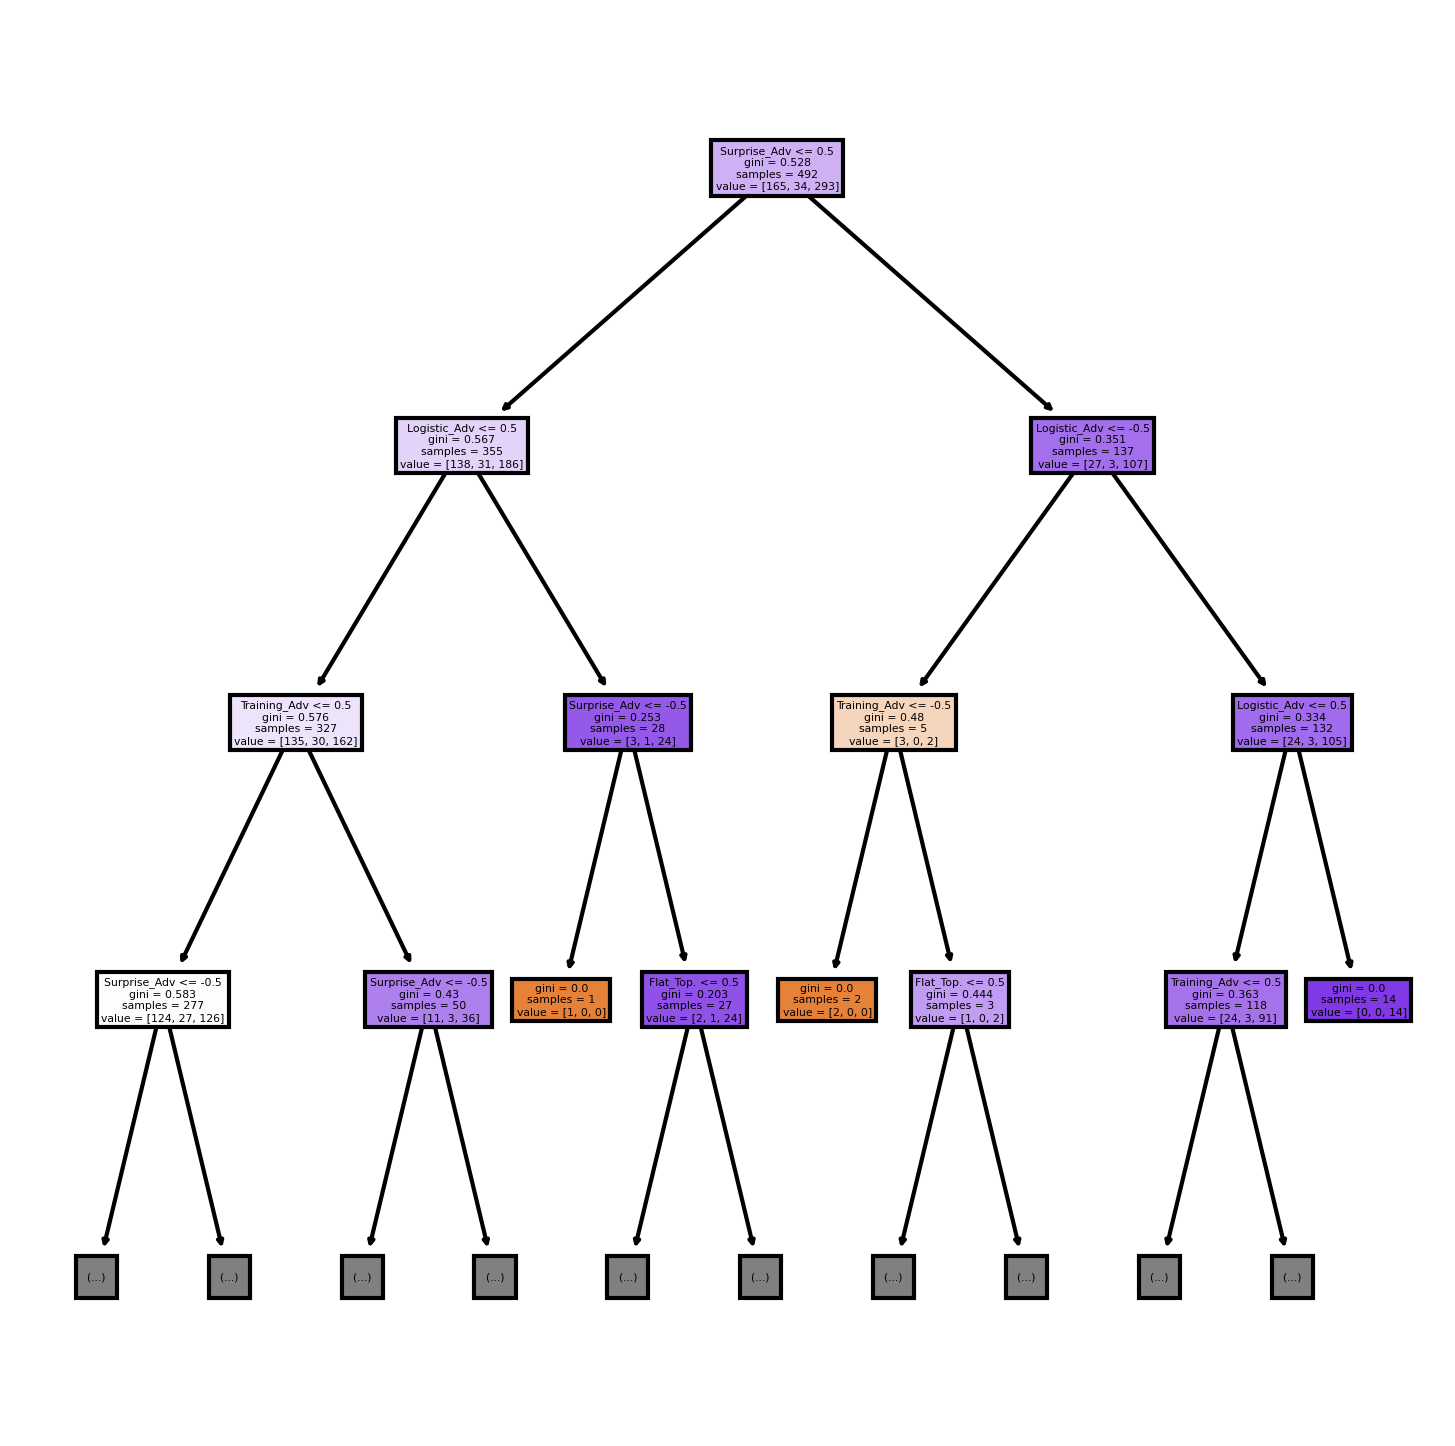

In [61]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (6,6), dpi=300)
tree.plot_tree(tf_clf_tree, max_depth=3,feature_names = list(feats_top_fol.columns), filled=True)
plt.show()

C:\Users\jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\jonat\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

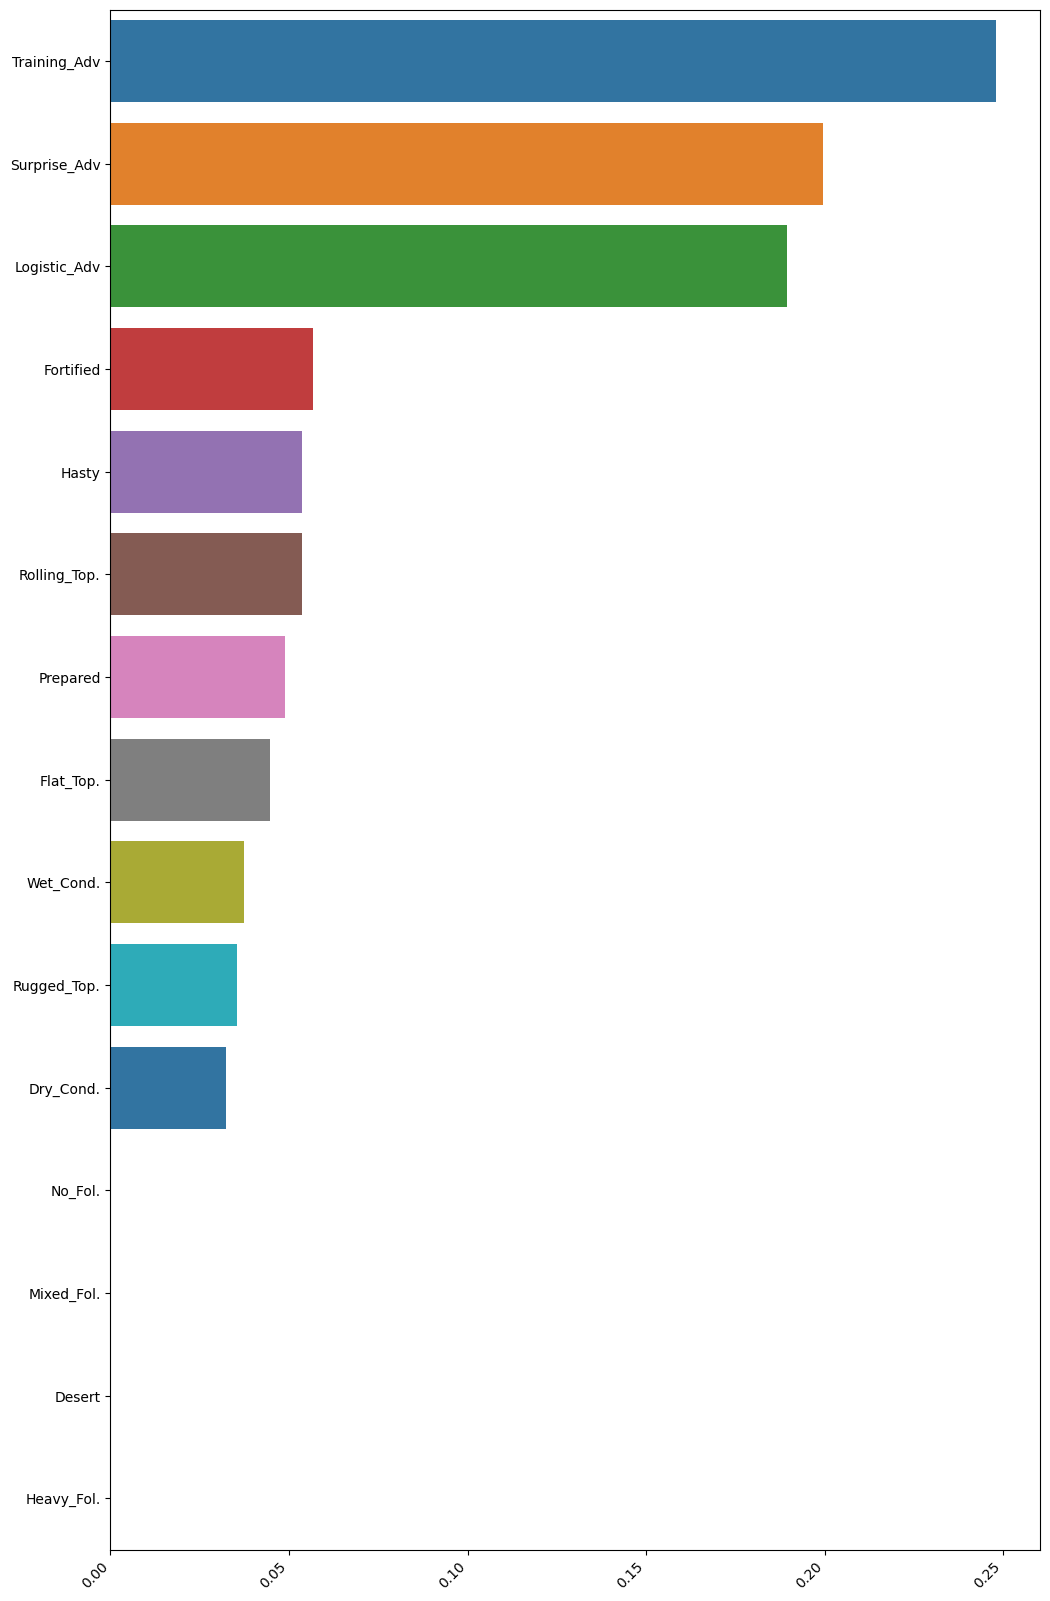

In [63]:
imp_feats = forest.feature_importances_
imp_feats = pd.Series(data = imp_feats, index = feats.columns)
imp_feats.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(12, 20))
chart = sns.barplot(x=imp_feats, y=imp_feats.index, palette=sns.color_palette( n_colors=len(imp_feats)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Above is a feature importantce graph depicting some of the most important aspects identified by the random forest model including all variables. As was identified in the previous project, maintaining well trained troops is a very large aspect when it comes to winning a battle. Also, it is self explanatory that surpise is another important aspect of winning a fight. While it may seem unimportant at its surface, I had an idea that maintaining logistic superiority could be incredibly important, as providing troops with food, munitions, medical service, and other amenities is important. Though I also realize that armies with good logistic lines could also just correlate with more advanced or equipped nation that stands a better chance at winning anyway. Again, to my surprise, the topography and level of foliage of a battlefield does not serve as large of a purpose as I initially imagined, which could again be attributed to the attacker choosing to engage.

### **Conclusion and Impact**

While the accuracy of the most accurate model was rather low, it still managed to out-perform the baseline. Despite this, I am not entirely sure that this model would be useful to those potentially putting the lives of others at risk. What goes into winning a battle is a countless number of different factors, and to some degree, a bit of luck. While creating a model to predict the outcome of a future battle is rather interesting, some factors are unable to be measured, such as troop morale, leadership experience, or the wild card of luck. However, the models created are not entirely useless and some information can be gleaned from them, that being some of the most important factors of warfare. It can be said with confidence that well trained troops, well maintained logistics and the element of surprise all come in handy during a fight. At this point in its life, I could not recommend the use of this model to those in leadership positions, or at least I could not recommend making final decisions based off of it, which could lead to needless loss of life without the guarantee of victory. In the future as well, if a better working model was to fall into the hands of those with bad or evil intentions, it could be used as a weapon of sorts.

### **References**
Dataset:

https://www.kaggle.com/datasets/residentmario/database-of-battles/code

Manual discussing some of the factors that go into warfare:

https://www.marines.mil/Portals/1/Publications/MCDP%201%20Warfighting.pdf